# Recommender Systems

Chapter 22 of [Data Science from Scratch](http://shop.oreilly.com/product/0636920033400.do). Joel's code: [recommender_systems.py](https://github.com/joelgrus/data-science-from-scratch/blob/master/code-python3/recommender_systems.py)

In [61]:
from collections import Counter, defaultdict
import math
import os
import sys
import matplotlib.pyplot as plt

In [13]:
book_dir = '/Users/CBare/Documents/projects/data-science-from-scratch'
sys.path.extend(os.path.join(book_dir, 'chapter_{:02d}'.format(i)) for i in [3,4,5,6,7,8])

In [14]:
from vector import dot, magnitude, scalar_multiply, distance
from matrix import make_matrix, shape, get_row, get_column

In [68]:
users_interests = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

In [69]:
popular_interests = Counter(interest
    for user_interests in users_interests
        for interest in user_interests).most_common()

In [70]:
def most_popular_new_interests(user_interests, max_results=5):
    suggestions = [(interest, frequency)
                   for interest, frequency in popular_interests
                   if interest not in user_interests]
    return suggestions[:max_results]

In [71]:
most_popular_new_interests(users_interests[1])

[('Python', 4), ('R', 4), ('Big Data', 3), ('Java', 3), ('statistics', 3)]

In [72]:
most_popular_new_interests(users_interests[3])

[('Big Data', 3), ('HBase', 3), ('Java', 3), ('Hadoop', 2), ('Cassandra', 2)]

## User similarity matrix

In [73]:
def cosine_similarity(v, w):
    return dot(v, w) / math.sqrt(dot(v, v) * dot(w, w))

In [74]:
unique_interests = sorted(list({interest
                                for user_interests in users_interests
                                    for interest in user_interests}))

In [75]:
unique_interests

['Big Data',
 'C++',
 'Cassandra',
 'HBase',
 'Hadoop',
 'Haskell',
 'Java',
 'Mahout',
 'MapReduce',
 'MongoDB',
 'MySQL',
 'NoSQL',
 'Postgres',
 'Python',
 'R',
 'Spark',
 'Storm',
 'artificial intelligence',
 'databases',
 'decision trees',
 'deep learning',
 'libsvm',
 'machine learning',
 'mathematics',
 'neural networks',
 'numpy',
 'pandas',
 'probability',
 'programming languages',
 'regression',
 'scikit-learn',
 'scipy',
 'statistics',
 'statsmodels',
 'support vector machines',
 'theory']

In [76]:
def make_user_interest_vector(user_interests):
    """given a list of interests, produce a vector whose ith element is 1
    if unique_interests[i] is in the list, 0 otherwise"""
    return [1 if interest in user_interests else 0
            for interest in unique_interests]

In [77]:
user_interest_matrix = [make_user_interest_vector(user_interest) for user_interest in users_interests]

In [78]:
user_similarities = [[cosine_similarity(interest_vector_i, interest_vector_j)
                      for interest_vector_j in user_interest_matrix]
                     for interest_vector_i in user_interest_matrix]

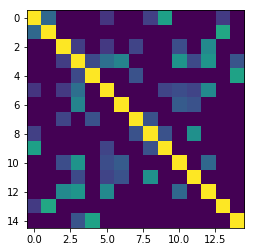

In [79]:
plt.imshow(user_similarities, cmap='viridis', interpolation='nearest')
plt.show()

In [80]:
def most_similar_users_to(user_id):
    pairs = [(other_user_id, similarity)
             for other_user_id, similarity in
             enumerate(user_similarities[user_id])
             if user_id != other_user_id and similarity > 0]
    
    return sorted(pairs,
                  key=lambda pair: pair[1],
                  reverse=True)

In [81]:
most_similar_users_to(0)

[(9, 0.5669467095138409),
 (1, 0.3380617018914066),
 (8, 0.1889822365046136),
 (13, 0.1690308509457033),
 (5, 0.1543033499620919)]

In [82]:
def user_based_suggestions(user_id, include_current_interests=False):
    # sum up the similarities
    suggestions = defaultdict(float)
    for other_user_id, similarity in most_similar_users_to(user_id):
        for interest in users_interests[other_user_id]:
            suggestions[interest] += similarity

    # convert them to a sorted list
    suggestions = sorted(suggestions.items(),
                         key=lambda pair: pair[1],
                         reverse=True)

    # and (maybe) exclude already-interests
    if include_current_interests:
        return suggestions
    else:
        return [(suggestion, weight)
                for suggestion, weight in suggestions
                if suggestion not in users_interests[user_id]]


In [83]:
user_based_suggestions(0)

[('MapReduce', 0.5669467095138409),
 ('MongoDB', 0.50709255283711),
 ('Postgres', 0.50709255283711),
 ('NoSQL', 0.3380617018914066),
 ('neural networks', 0.1889822365046136),
 ('deep learning', 0.1889822365046136),
 ('artificial intelligence', 0.1889822365046136),
 ('databases', 0.1690308509457033),
 ('MySQL', 0.1690308509457033),
 ('Python', 0.1543033499620919),
 ('R', 0.1543033499620919),
 ('C++', 0.1543033499620919),
 ('Haskell', 0.1543033499620919),
 ('programming languages', 0.1543033499620919)]

## Interest similarity

In [84]:
interest_user_matrix = [[user_interest_vector[j]
                         for user_interest_vector in user_interest_matrix]
                        for j, _ in enumerate(unique_interests)]

In [85]:
interest_similarities = [[cosine_similarity(user_vector_i, user_vector_j)
                          for user_vector_j in interest_user_matrix]
                         for user_vector_i in interest_user_matrix]

In [86]:
def most_similar_interests_to(interest_id):
    similarities = interest_similarities[interest_id]
    pairs = [(unique_interests[other_interest_id], similarity)
             for other_interest_id, similarity in enumerate(similarities)
             if interest_id != other_interest_id and similarity > 0]
    return sorted(pairs,
                  key=lambda pair: pair[1],
                  reverse=True)

In [88]:
most_similar_interests_to(0)

[('Hadoop', 0.8164965809277261),
 ('Java', 0.6666666666666666),
 ('MapReduce', 0.5773502691896258),
 ('Spark', 0.5773502691896258),
 ('Storm', 0.5773502691896258),
 ('Cassandra', 0.4082482904638631),
 ('artificial intelligence', 0.4082482904638631),
 ('deep learning', 0.4082482904638631),
 ('neural networks', 0.4082482904638631),
 ('HBase', 0.3333333333333333)]

In [87]:
def item_based_suggestions(user_id, include_current_interests=False):
    suggestions = defaultdict(float)
    user_interest_vector = user_interest_matrix[user_id]
    for interest_id, is_interested in enumerate(user_interest_vector):
        if is_interested == 1:
            similar_interests = most_similar_interests_to(interest_id)
            for interest, similarity in similar_interests:
                suggestions[interest] += similarity

    suggestions = sorted(suggestions.items(),
                         key=lambda pair: pair[1],
                         reverse=True)

    if include_current_interests:
        return suggestions
    else:
        return [(suggestion, weight)
                for suggestion, weight in suggestions
                if suggestion not in users_interests[user_id]]

In [89]:
item_based_suggestions(0)

[('MapReduce', 1.861807319565799),
 ('MongoDB', 1.3164965809277263),
 ('Postgres', 1.3164965809277263),
 ('NoSQL', 1.2844570503761732),
 ('MySQL', 0.5773502691896258),
 ('databases', 0.5773502691896258),
 ('Haskell', 0.5773502691896258),
 ('programming languages', 0.5773502691896258),
 ('artificial intelligence', 0.4082482904638631),
 ('deep learning', 0.4082482904638631),
 ('neural networks', 0.4082482904638631),
 ('C++', 0.4082482904638631),
 ('Python', 0.2886751345948129),
 ('R', 0.2886751345948129)]